# Pytorch로 선형회귀(Linear Regression) 구현

***
## 목적

선형회귀분석은 주어진 **데이터를 가장 잘 설명하는 직선** 하나를 찾는 것이다.

하나의 독립변수에 대하여 선형회귀분석을 하면 **단순선형회귀**라고 하고 독립변수가 여러 개인 경우에는 **다중선형회귀**라고 한다.

단순선형회귀를 한다는 것은 임의의 x와 y라는 데이터가 주어졌을 때, $y = w \times x + b$라는 직선의 방정식에서 **데이터를 가장 잘 표현하는 변수 w와 b를 찾는 것**이다.

이때 **w**와 **b**는 **가중치**(*weight*)와 **편차**(*bias*)를 의미한다.

***
## 손실함수(Loss Function)

'데이터를 가장 잘 설명한다'는 것은 '비교가 가능하다'는 뜻을 내제하고 있을 수 있다.<br>
즉, 어떤 *w*, *b*쌍에 대해서 데이터와 얼마나 잘 맞는지 수치적으로 계산을 할 수 있어야 하는데, 이때 사용되는 척도 중 대표적인 것이 **평균제곱오차(Mean Squared Error, MSE)**가 있다.

**MSE**는 예측한 값과 실제 데이터 값과의 차이를 제곱하여 평균을 낸다는 것인데 $\hat y$은 *w*와 *b*에 의해 결정되기 때문에 각각의 *w*,*b*를 비교하는게 가능해진다.
***
### $$ MSE = {1 \over n} \sum_{i=1}^n(\hat y -y)^2 $$
***

척도를 찾았으니 이제 목표는 MSE를 최소화하는 최적의 *w*,*b*를 찾는 것이다. 하지만 어떻게?

모든 범위를 하나하나 살펴보거나 무작위로 찾는다는 것은 비효율적이다.

오차는 예측값과 목푯값의 차이이며, 이를 나타내는 것은 **손실 함수(loss function)** 또는 **비용 함수(cost function)**이다.

여기서 예측값은 *w*와 *b*에 의해 구해지므로 이러한 관계를 통해 최적의 *w*와 *b*를 구하는 것을 생각해 볼 수 있다.


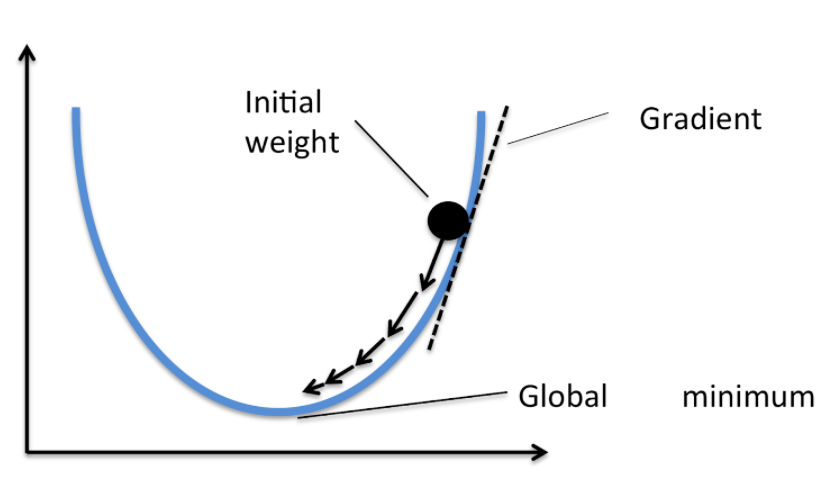


**X축은 가중치(w), Y축은 오차(loss : J(w))**

다음 그림은 w에 대한 2차 함수이다. 이런 상황에서 **loss가 최소가 되는 지점, 그래프의 최소점(w에 대한 미분값 : 2차 함수의 기울기 = 0)**을 구해야 하는데 데이터의 크기가 커질수록 최적의 w를 찾기가 어려워진다.

따라서 대부분의 딥러닝 모델에서는 **경사하강법(Gradient Descent)**라는 방법을 사용하는데, 여기서 말하는 **'경사'**는 **기울기(gradient)**로서 미분 값을 의미 하고, 미분 값이라는 것은 그림에서 볼 수 있듯이 순간적인 기울기를 의미한다.

주어진 w에서 경사를 구하고 이를 통해 지속적으로 w를 업데이트함으로써 오차의 극솟값을 찾아가다보면 언젠간 최적의 w를 찾을 수 있다는 것이다.

식으로 표현하면 다음과 같다. 
***
### $$w_{t+1} = w_t - gradient \times learning \ rate$$
***

식을 보면 **학습률(learning rate)**이 나오는데 학습률은 **계산한 기울기에 비례하여 변수인 w를 얼마만큼 업데이트할지 결정하는 수치인지를 의미한다.**

예를 들어 $w_t$가 3이었고 이때의 기울기가 2, 학습률이 0.5라면 $w_{t+1}$는 $3 - 2 \times 0.5 = 2$로 업데이트 된다.

**w가 점점 오차가 최소인 지점에 가까워질수록** 기울기는 작아지기 때문에 점점 적게 업데이트되고, 최종적으로는 오차를 최소화하는 w로 수렴하게 된다.

In [1]:
import torch
import torch.nn as nn # 신경망 모델을 구축하기 위한 데이터 구조나 레이어가 정의, Linear, RNN, Relu, 손실함수가 담겨있음
import torch.optim as optim # SGD를 기점으로 최적화 함수들 구현
import torch.nn.init as init # 텐서에 초깃값을 주기 위해 필요한 함수들이 존재
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 텐서 생성,
X = torch.Tensor(2,3)

X라는 변수에 파이토치 텐서를 하나 생성해서 지정하는데 이때의 shape는 2,3이다.

텐서 안 원소에는 임의의 난수가 들어가며 원하는 값으로 초기화하려면 인수로 배열을 전달한다.

In [3]:
# 배열 안 원소 지정
X = torch.tensor([[1,2,3],[4,5,6]])

In [4]:
X

tensor([[1, 2, 3],
        [4, 5, 6]])

**torch.tensor 함수**는 인수로 **data, dtype, device, requires_grad**등을 받는다.

**data**<br>
> 배열이 들어감<br>

**dtype**<br>
> 데이터를 저장할 자료형이 들어감, 자료형의 기본값은 **FloatTensor**<br>

**device**<br>
> 이 텐서를 어느 기기에 올릴 것인지를 명시<br>

**requires_grad**<br>
> 이 텐서에 대한 기울기를 저장할지 여부를 지정, 기본값은 False이며 명시적으로 지정시 True

In [5]:
# 2.0, 3.0을 담은 x 데이터
x = torch.tensor(data = [2.0, 3.0], requires_grad = True)

# x를 제곱
y = x**2

# 2*x^2 + 3  = z를 계산
z = 2*y +3

print(x)
print(y)
print(z) 

tensor([2., 3.], requires_grad=True)
tensor([4., 9.], grad_fn=<PowBackward0>)
tensor([11., 21.], grad_fn=<AddBackward0>)


In [6]:
# 타깃값 생성
target = torch.tensor([3.0,4.0])

# z와 타깃값의 절대값 차이를 계산 -> 하나의 값으로 sum
loss = torch.sum(torch.abs(z - target))

# 연산 그래프를 쭉 따라가면서 x에 대한 기울기를 계산
loss.backward()

# x에 대한 기울기를 계산
# y와 z는 잎 노드가 아님(x는 그 자체가 값이나 y와 z는 계산되는 값이다.)
print(x.grad, y.grad, z.grad)

tensor([ 8., 12.]) None None


C:\Users\admin\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(
C:\Users\admin\AppData\Local\Temp/ipykernel_6476/1064268694.py:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 f

## 데이터 생성

In [7]:
num_data = 1000 # 사용할 데이터 수
num_epoch = 500 # 경사하강법 반복 횟수

# [num_data,1]인 텐서를 생성하고
# init.uniform_()이라는 함수를 통해 -10부터 10까지 균등하게 초기화, 따라서 -10에서 10까지 랜덤 수 입력
x = init.uniform_(torch.Tensor(num_data, 1),-10,10) 

# 표준 정규분포(mean = 0, std = 1)를 따르는 noise 생성
noise = init.normal_(torch.FloatTensor(num_data, 1),std = 1)
y = 2*x + 3
# 생성한 노이즈를 y식에 더함
y_noise = 2*(x + noise)+3 

## 생성한 데이터 시각화

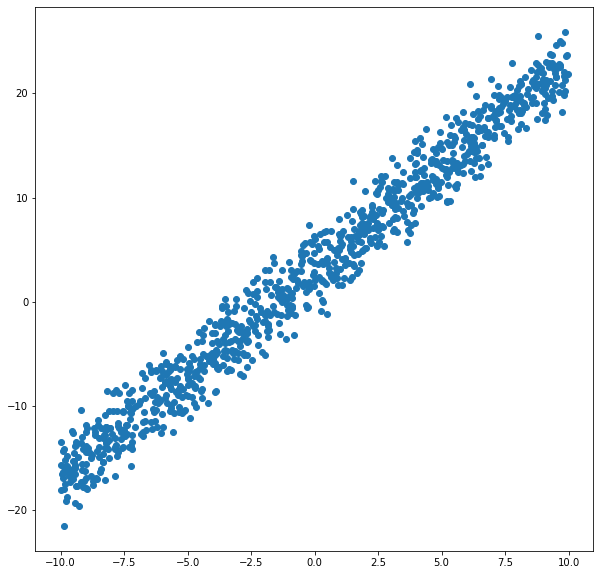

In [8]:
plt.figure(figsize = (10,10))
plt.scatter(x.numpy(),y_noise.numpy()) # 시각화할때는 가급적이면 tensor를 numpy로 변환하자.
plt.show()

## 모델 생성

In [9]:
# 1개의 특성과 1개의 y를 가진 선형 모델 생성
model = nn.Linear(1,1)
# 모델에서 나온 결과와 y_noise와의 차이를 구하는 척도(L1 loss)를 사용
loss_func = nn.L1Loss()

#### L1 Loss : 차이의 절대값의 평균
$$ loss(x,y) = {1 \over n} \sum \vert x_i - y_i \vert$$



## 옵티마이저 설정

In [10]:
# 확률적 경사하강법 사용, 학습률 0.01
optimizer = optim.SGD(model.parameters(), lr = 0.01)

## 모델 학습

In [11]:
# 손실 변화값 저장할 list
loss_arr = []

# 목표값 = y_noise(실제값)
label = y_noise

# 지정한 학습 횟수만큼 반복
for i in range(num_epoch) :
    # 각 반복시 이전 학습의 기울기를 0으로 초기화
    # 기울기를 지우지 않으면 기존의 업데이트 때문에 새로운 기울기를 구할 수 없다.
    optimizer.zero_grad()
    
    # 입력값 x를 모델에 넣어 결과값을 얻음
    output = model(x)
    
    # 결과값과 목표값의 차이를 L1 손실 함수로 계산
    loss = loss_func(output, label) 
    
    # 손실에 대한 기울기를 계산
    loss.backward()
    
    # 구한 기울기를 이용해 모델의 변수를 업데이트함 # model.parameters에서 리턴
    optimizer.step()
        
    param_list = list(model.parameters())
    print(param_list[0].item(),param_list[1].item())
    # 손실을 loss_arr에 추가
    loss_arr.append(loss.detach().numpy()) # detach를 호출하면 연산 기록으로부터 분리하여 이후 추적을 방지한다.
    # auto grad를 사용 시 필요한 것에만 옵션을 붙이고 끄기위함.

-0.45387911796569824 -0.09905801713466644
-0.404780775308609 -0.09779801964759827
-0.3557998538017273 -0.09647802263498306
-0.30696582794189453 -0.09507802128791809
-0.25813180208206177 -0.09367801994085312
-0.209297776222229 -0.09227801859378815
-0.1605364978313446 -0.09083801507949829
-0.1117752194404602 -0.08939801156520844
-0.0630139410495758 -0.08795800805091858
-0.014436442404985428 -0.0864580050110817
0.03411572799086571 -0.08493800461292267
0.08266790211200714 -0.08341800421476364
0.13110291957855225 -0.08185800164937973
0.17940355837345123 -0.08025800436735153
0.22757601737976074 -0.07861800491809845
0.27565106749534607 -0.07691800594329834
0.32357528805732727 -0.0751580074429512
0.37149304151535034 -0.07341800630092621
0.4193604588508606 -0.07165800780057907
0.4671720564365387 -0.06985800713300705
0.5147887468338013 -0.067998006939888
0.5622632503509521 -0.06609800457954407
0.6094909310340881 -0.06411800533533096
0.6563444137573242 -0.062018007040023804
0.7029098868370056 -0.

2.0043203830718994 2.1042211055755615
2.0045888423919678 2.1078810691833496
2.004913330078125 2.111521005630493
2.0051259994506836 2.115140914916992
2.005202054977417 2.1187407970428467
2.0052781105041504 2.122340679168701
2.005354166030884 2.1259405612945557
2.005430221557617 2.12954044342041
2.0056540966033936 2.133120536804199
2.005751371383667 2.1366806030273438
2.0060417652130127 2.140200614929199
2.0063321590423584 2.1437206268310547
2.006533145904541 2.1472206115722656
2.006683349609375 2.150700569152832
2.006680727005005 2.154160499572754
2.006516218185425 2.1576004028320312
2.006410598754883 2.161020517349243
2.006304979324341 2.164440631866455
2.0060527324676514 2.1678407192230225
2.005992889404297 2.1711807250976562
2.005831241607666 2.174480676651001
2.0055835247039795 2.177760601043701
2.005335807800293 2.1810405254364014
2.0050880908966064 2.1843204498291016
2.00484037399292 2.1876003742218018
2.0045926570892334 2.190880298614502
2.004683017730713 2.194120407104492
2.0047

## 학습 후 데이터와 모델 결과값 확인

- 회색 점들은 노이즈가 있는 모델 데이터

- 빨간색 선이 데이터를 가지고 학습된 가중치, 편차로 그린 직선이다.

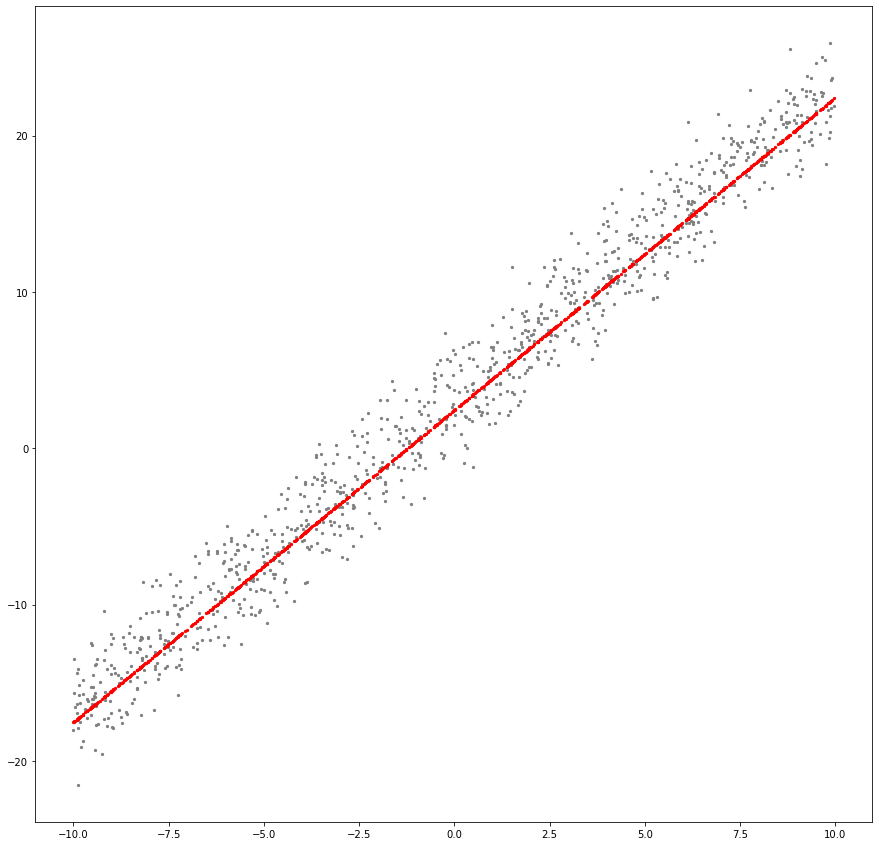

In [12]:
# 단순선형회귀 학습 결과
plt.figure(figsize = (15,15))
plt.scatter(x.numpy(), y_noise.numpy(), s = 5, c = 'gray')
plt.scatter(x.detach().numpy(), output.detach().numpy(), s = 5, c = 'red')
plt.show()

## 손실 그래프

- 학습이 늘어날수록 손실이 줄어드는 것을 확인할 수 있다.

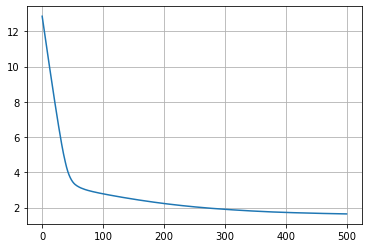

In [13]:
plt.plot(loss_arr)
plt.grid()
plt.show()

## 학습 후 모델 변수 값 확인

- 현재 모델이 가지고 있는 **$w$**와 **$b$**의 수치가 몇인지 확인이 가능하다.

In [14]:
param_list = list(model.parameters())
print("Weight :",param_list[0].item(),"\nBias :",param_list[1].item())

Weight : 1.998176097869873 
Bias : 2.4550201892852783
